# Case 3. Patient Drug Review
Name: Dmytro Izotov<br>
Last edited: 17.03.2019<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## 1. Objectives

The aim of this assignment is to learn to use neural networks to process text data and predict ratings associated to the text. The main objective is to use recurrent and convolutional neural networks to create a predictor for a collection of patient drug reviews extracted from Drugs.com. Drugs.com is a comprehensive source of drug information online.

## 2. Required libraries

In [20]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D, GRU
from sklearn.metrics import accuracy_score, confusion_matrix

## 3. Data description and preprocessing

I'm using preprocessed [dataset](https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018/home)<br> These are two files drugsComTrain_raw.csv and drugsComTest_raw.csv. One for testing and one for training. Both of them contain 7 columns (Id, DrugName, Condition, Review, Rating, Date, UsefulCount). I'm going to use only review and rating columns. Lets preprocesse them:

In [3]:
train = pd.read_csv(r"C://Users//Dizotoff//Desktop//drugsComTrain_raw.csv")
test = pd.read_csv(r"C://Users//Dizotoff//Desktop//drugsComTest_raw.csv")
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
#Lets convert rating to 3 types of one_hot_labels which correspond to it (negative, neutral, positive)
train['rating'] = -1*(train['rating'] <= 4) + 1*(train['rating'] >= 7)
one_hot_labels_train = to_categorical(train['rating'], num_classes = 3)

test['rating'] = -1*(test['rating'] <= 4) + 1*(test['rating'] >= 7)
one_hot_labels_test = to_categorical(test['rating'], num_classes = 3) 

print(one_hot_labels_train)

[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [5]:
# Labels now ready, lets grab review column and tokenize it. I decided to stick to 1000 words because that is a 
# popular solution for this kind of a problem

samples_train = train['review']
samples_test = test['review']

tokenizer = Tokenizer(num_words = 1000)

tokenizer.fit_on_texts(samples_train)
sequences_train = tokenizer.texts_to_sequences(samples_train)
x_train = pad_sequences(sequences_train, maxlen = 500)

tokenizer = Tokenizer(num_words = 1000)

tokenizer.fit_on_texts(samples_test)
sequences_test = tokenizer.texts_to_sequences(samples_test)
x_test = pad_sequences(sequences_test, maxlen = 500)

## 4. Modeling and compilation


I decided to test two models.

#### First model

In [16]:
# First simple model has 64 embedding layer and 500 sequence length. I'm using relu activation because it's 
# not expensive like sigmoid or TanH, learns faster, avoids the vanishing gradient problem. That is binary regression
# problem, so softmax activation function at output layer.

model = Sequential()
model.add(Embedding(1000, 64, input_length = 500))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 64)           64000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1024032   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 1,088,131
Trainable params: 1,088,131
Non-trainable params: 0
_________________________________________________________________


#### Second model

In [13]:
# Second model is more complicated. It includes embedding layer, convnet and GRU layers to increase the language 
# "understanding" of the network
model_2 = Sequential()
model_2.add(Embedding(1000, 32, input_length=500))
model_2.add(Conv1D(32, 9, activation='relu'))
model_2.add(MaxPooling1D(5))
model_2.add(Conv1D(32, 9, activation='relu'))
model_2.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
model_2.add(Dense(1024, activation = 'relu'))
model_2.add(Dense(3, activation = 'softmax'))

model_2.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           32000     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 492, 32)           9248      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 90, 32)            9248      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              33792     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total para

## 5. Training and Validation

#### First model

In [19]:
#Fist model
t1 = time.time()
history = model.fit(x_train, one_hot_labels_train,
                   epochs = 10,
                   batch_size = 32,
                   validation_split = 0.2)
t2 = time.time()
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))

Train on 129037 samples, validate on 32260 samples
Epoch 1/10
129037/129037 [==============================] - 246s 2ms/step - loss: 0.6176 - acc: 0.7653 - val_loss: 0.5992 - val_acc: 0.7759
Epoch 2/10
129037/129037 [==============================] - 241s 2ms/step - loss: 0.5336 - acc: 0.7973 - val_loss: 0.5933 - val_acc: 0.7728
Epoch 3/10
129037/129037 [==============================] - 242s 2ms/step - loss: 0.4686 - acc: 0.8253 - val_loss: 0.6032 - val_acc: 0.7835
Epoch 4/10
129037/129037 [==============================] - 246s 2ms/step - loss: 0.4189 - acc: 0.8470 - val_loss: 0.6397 - val_acc: 0.7941
Epoch 5/10
129037/129037 [==============================] - 254s 2ms/step - loss: 0.3791 - acc: 0.8617 - val_loss: 0.7410 - val_acc: 0.7956
Epoch 6/10
129037/129037 [==============================] - 254s 2ms/step - loss: 0.3461 - acc: 0.8771 - val_loss: 0.7134 - val_acc: 0.7919
Epoch 7/10
129037/129037 [==============================] - 251s 2ms/step - loss: 0.3169 - acc: 0.8884 - val_

#### Second model

In [14]:
#Second model
t1 = time.time()
history_2 = model_2.fit(x_train, one_hot_labels_train,
                   epochs = 10,
                   batch_size = 32,
                   validation_split = 0.2)
t2 = time.time()
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))

Train on 129037 samples, validate on 32260 samples
Epoch 1/10
129037/129037 [==============================] - 756s 6ms/step - loss: 0.6365 - acc: 0.7579 - val_loss: 0.5740 - val_acc: 0.7820
Epoch 2/10
129037/129037 [==============================] - 749s 6ms/step - loss: 0.5529 - acc: 0.7957 - val_loss: 0.5632 - val_acc: 0.7849
Epoch 3/10
129037/129037 [==============================] - 748s 6ms/step - loss: 0.5176 - acc: 0.8082 - val_loss: 0.5622 - val_acc: 0.7903
Epoch 4/10
129037/129037 [==============================] - 749s 6ms/step - loss: 0.5010 - acc: 0.8157 - val_loss: 0.5466 - val_acc: 0.7964
Epoch 5/10
129037/129037 [==============================] - 758s 6ms/step - loss: 0.4903 - acc: 0.8211 - val_loss: 0.5506 - val_acc: 0.7975
Epoch 6/10
129037/129037 [==============================] - 754s 6ms/step - loss: 0.4840 - acc: 0.8245 - val_loss: 0.6080 - val_acc: 0.7782
Epoch 7/10
129037/129037 [==============================] - 753s 6ms/step - loss: 0.4815 - acc: 0.8272 - val_

## 6. Evaluation

#### First model

<Figure size 432x288 with 0 Axes>

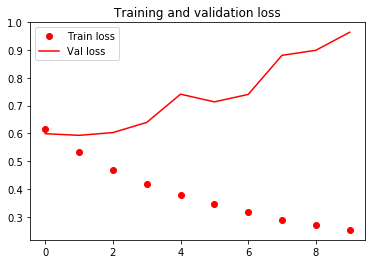

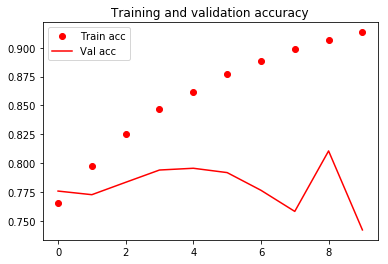

<Figure size 432x288 with 0 Axes>

In [23]:
#First model
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'ro', label='Train loss')
plt.plot(epochs, val_loss, 'r', label='Val loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'ro', label='Train acc')
plt.plot(epochs, val_acc, 'r', label='Val acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#### Second model

<Figure size 432x288 with 0 Axes>

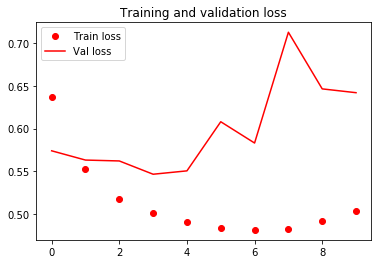

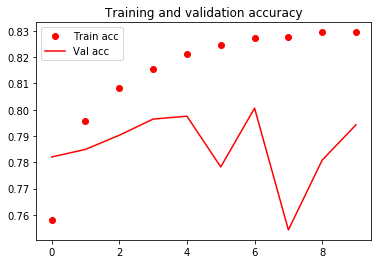

<Figure size 432x288 with 0 Axes>

In [15]:
#Second model
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'ro', label='Train loss')
plt.plot(epochs, val_loss, 'r', label='Val loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'ro', label='Train acc')
plt.plot(epochs, val_acc, 'r', label='Val acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

## 7. Results and Discussion

In [28]:
loss,acc = model_2.evaluate(x_test, one_hot_labels_test)
print("Accuracy: {:.4f}".format(acc))

53766/53766 [==============================] - 92s 2ms/step
Accuracy: 0.6270


The first model has overfitted quickly, so I decided to stick to the second model which has final accuracy of 62% (tested with test dataset), it's not the great accuracy value, but I thing that it represents a futher direction in which I could act. Tinkering with convnet and GRU layers could help to give better result. Also it seems that the dataset is quite imbalances which obviously has the impact on the final accuracy. 
Unfortunatelly, it takes too much time for me to train the networks, so I cant experiment more.   